# Agent Based Staircase Model

## This notebook implements an agent-based approach to modeling the travel of people up and down a staircase simultaneously. 

Each agent has the following characteristics:
- Age (years)
- Sex (M/F)
- Height (cm)
- Weight (kg)
- Group
- Stepping Pattern (traditional: one footstep per stair, double: two footsteps per stair, skip: only step on every other stair)
    - Sampled from a distribution dependent on the age, height, and weight of the agent
- Intended Final Destination
- Desired Velocity $v$ (m/s)
- Ascending/Descending

The following parameters are used to define the staircase domain:
- The number of stairs $N$
- The length of each step ${l}_{i = 1}^N $
- The width of each step ${w}_{i=1}^N $

It is assumed that the steps are continuous in that the length of the far edge must align with the length of the close edge of the next step and vice versa.

Groups arrive at the staircase according to a Poisson Arrival Process. When a group arrives, the size of the group is sampled from a distribution and each of the members of the group are introduced into the model. 

The initial locations of the agents within the staircase are found by first introducing them in a horizonal arrangement (i.e. shoulder-to-shoulder) in an open space before the staircase subject to the same attracion and repulsions which govern movement within the staircase. This open space then narrows to match the dimensions of the fist stair, serving as a funnel. This enables the groups to form an inital arrangement on the staircase which resembles a natural group walking formation.

Attractive Forces:
- Desire to reach intended destination atop the staircase by following a linear trajectory (most efficient route between points a and b is a straight line)
- Desire to maintain intended velocity
- Desire to maintain a certain distance between group members
- Desire to obey agreed upon social convention (walking on the right side vs left side)

Repulsive Forces:
- Desire not to get too close to other people 
    - the strength of this desire depends on whether the other agent is a member of one's group and the direction in which they are traversing (e.g. One would have a stronger desire to avoid contact with someone going in the opposite direction)

These attractive and repulsive forces are then combined into a utility function which determines where the agent will step on the next stair in the $x$ dimension (along the width of the stair). 

The final output of this model is a dataset of simulated steps on each stair and their associated agent. These steps can easily be converted to represent the cumulative pressure placed on each stair over the time interval in which the simulation is run. With a long enough sample, we can then extrapolate to a larger time interval by assuming periodicity in the stepping patterns. 


In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

## Agent Class

In [18]:
class Agent:
    def __init__(self, unique_id, age, sex, height, weight, velocity, direction, group_id, position, foot, stride_length):
        self.unique_id = unique_id
        self.age = age
        self.sex = sex
        self.height = height
        self.weight = weight
        self.velocity = velocity
        self.direction = direction
        self.group_id = group_id
        self.position = position # (Stair, x, y)
        self.foot = foot
        self.stride_length = stride_length

    def update_position(self, utility_function, agents, staircase):
        utilities = utility_function(self, agents, staircase)
        probabilities = np.exp(utilities) / np.sum(np.exp(utilities))  # Softmax
        next_step = np.random.choice(len(utilities), p=probabilities)
        self.position = next_step
        if self.position[2] >= staircase.num_stairs or self.position[2] < 0:
            self.active = False  # Agent has exited the staircase
    
        

## Group Class

In [ ]:
class Group:
    def __init__(self, group_id, domain_width, domain_height, direction):
        """
        Initialize a Group.

        Parameters:
        - model: The model to which the group belongs.
        - group_id: Unique identifier for the group.
        - domain_width: Width of the domain (for horizontal spacing).
        - domain_height: Height of the domain (for vertical positioning).
        """
        self.group_id = group_id
        self.domain_width = domain_width
        self.domain_height = domain_height
        self.direction = direction

        # Sample group size from a right-skewed distribution (e.g., exponential distribution)
        self.group_size = max(1, int(np.random.exponential(scale=1.5)))  # Ensures at least 1 agent
        self.agents = []

        # Horizontal spacing for agents
        horizontal_spacing = domain_width / (self.group_size + 1)

        # Instantiate agents
        for i in range(self.group_size):
            unique_id = f"Group{group_id}_Agent{i}"
            x_position = (i + 1) * horizontal_spacing
            y_position = 0  # Bottom of the domain

            # Sample attributes for the agent
            age = np.random.randint(10, 70)  # Example age distribution
            sex = np.random.choice(["M", "F"])
            height = np.random.normal(170, 10)
            weight = np.random.normal(70, 15)
            stepping_pattern = np.random.choice(["traditional", "double", "skip"])
            velocity = np.random.uniform(0.5, 1.5)
            direction = np.random.choice(["ascending", "descending"])
            foot = np.random.choice(["left", "right"])

            # Create an Agent and set its initial position
            agent = Agent(unique_id, age, sex, height, weight, stepping_pattern, velocity, direction, group_id)
            agent.position = (x_position, y_position)

            self.agents.append(agent)


## Staircase Class

Staircase Domain with Funnels on Each End

IndexError: list index out of range

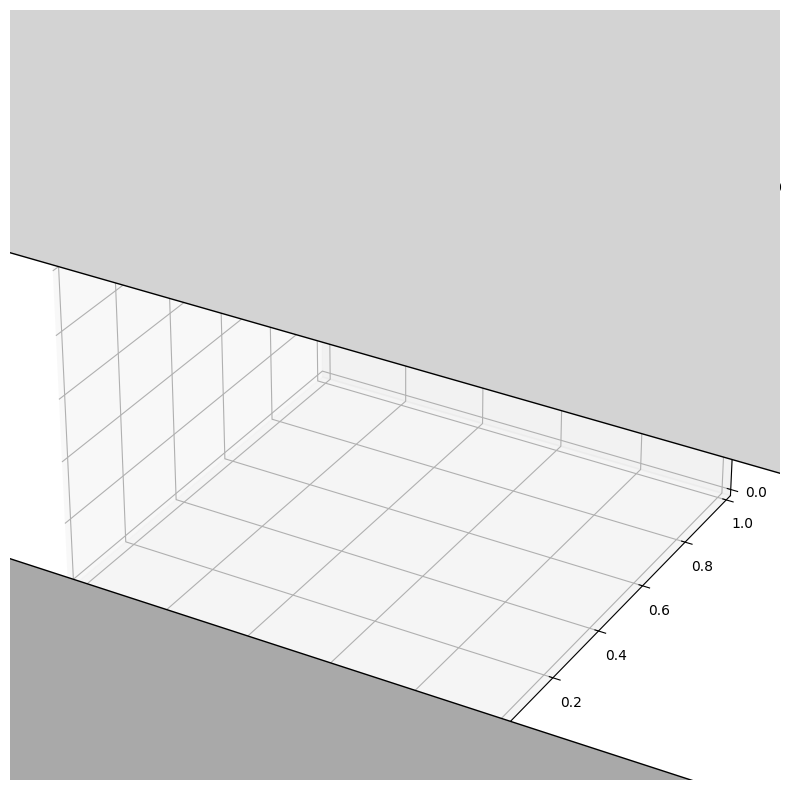

In [33]:

class Staircase:
    def __init__(self, num_stairs, step_widths, step_depths, step_heights, funnel_length, funnel_width_start, funnel_width_end):
        """
        Initializes a staircase with aligned funnels and configurable steps.

        Args:
            num_stairs (int): Number of steps in the staircase.
            step_widths (list): List of widths for each step.
            step_depths (list): List of depths (tread) for each step.
            step_heights (list): List of heights (rise) for each step.
            funnel_length (float): Length of both the top and bottom funnels.
            funnel_width_start (float): Width of the bottom funnel.
            funnel_width_end (float): Width of the top funnel.
        """
        self.num_stairs = num_stairs
        self.step_widths = step_widths
        self.step_depths = step_depths
        self.step_heights = step_heights
        self.funnel_length = funnel_length
        self.funnel_width_start = funnel_width_start
        self.funnel_width_end = funnel_width_end

        # Validate input lengths
        if not (len(step_widths) == len(step_depths) == len(step_heights) == num_stairs):
            raise ValueError("step_widths, step_depths, and step_heights must have the same length as num_stairs.")

    def draw(self):
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Draw bottom funnel
        bottom_funnel_points = [
            [-self.funnel_width_start / 2, -self.funnel_length, 0],
            [self.funnel_width_start / 2, -self.funnel_length, 0],
            [self.step_widths[0] / 2, 0, 0],
            [-self.step_widths[0] / 2, 0, 0],
        ]
        self._draw_funnel(ax, bottom_funnel_points)

        # Draw staircase
        current_z = 0
        current_y = 0
        for i in range(self.num_stairs):
            self._draw_step(ax, i, current_z, current_y)
            current_z += self.step_heights[i]
            current_y += self.step_depths[i]

        # Draw top funnel
        top_funnel_points = [
            [-self.step_widths[-1] / 2, current_y, current_z + self.step_heights[self.num_stairs-1]],
            [self.step_widths[-1] / 2, current_y, current_z + self.step_heights[self.num_stairs-1]],
            [self.funnel_width_end / 2, current_y + self.funnel_length, current_z + self.step_heights[self.num_stairs-1]],
            [-self.funnel_width_end / 2, current_y + self.funnel_length, current_z + self.step_heights[self.num_stairs-1]],
        ]
        self._draw_funnel(ax, top_funnel_points)

        # Set axis limits and labels
        ax.set_xlim(-self.funnel_width_start, self.funnel_width_start)
        ax.set_ylim(-self.funnel_length, current_y + self.funnel_length)
        ax.set_zlim(0, current_z + max(self.step_heights))
        ax.set_xlabel("X (Width)", fontsize=12, fontweight="bold")
        ax.set_ylabel("Y (Tread)", fontsize=12, fontweight="bold")
        ax.set_zlabel("Z (Rise)", fontsize=12, fontweight="bold")
        ax.set_title("3D Staircase Model with Funnels", fontsize=16, fontweight="bold")
        plt.show()

    def _draw_step(self, ax, i, z, y_offset):
        """
        Draws a single step in the staircase.

        Args:
            ax: Matplotlib 3D axis.
            i (int): Index of the step.
            z (float): Height of the step's base.
            y_offset (float): Offset in the Y-direction.
        """
        width = self.step_widths[i]
        depth = self.step_depths[i]
        height = self.step_heights[i]

        x = np.array([
            -width / 2, width / 2,
            width / 2, -width / 2,
        ])
        y = np.array([
            y_offset, y_offset,
            y_offset + depth, y_offset + depth,
        ])
        z = np.array([z + height, z + height, z + height, z + height])  # Elevated plane with consistent height

        vertices = [list(zip(x, y, z))]
        ax.add_collection3d(Poly3DCollection(vertices, facecolors='lightgray', edgecolors='black'))


    def _draw_funnel(self, ax, points):
        """
        Draws a funnel (either top or bottom).

        Args:
            ax: Matplotlib 3D axis.
            points (list): List of (x, y, z) coordinates defining the funnel.
        """
        points = np.array(points)
        x = points[:, 0]
        y = points[:, 1]
        z = points[:, 2]
        vertices = [list(zip(x, y, z))]
        ax.add_collection3d(Poly3DCollection(vertices, facecolors='darkgray', edgecolors='black'))


# Example usage
staircase_with_funnels_aligned = Staircase(
    num_stairs=10,         # Number of steps
    step_widths=[4] * 10,  # Width of each step
    step_depths=[2] * 10,  # Depth of each step
    step_heights=[1] * 10, # Height of each step
    funnel_length=5,       # Length of the funnels
    funnel_width_start=10, # Width of the bottom funnel
    funnel_width_end=6     # Width of the top funnel
)

staircase_with_funnels_aligned.draw()


## Stair Class

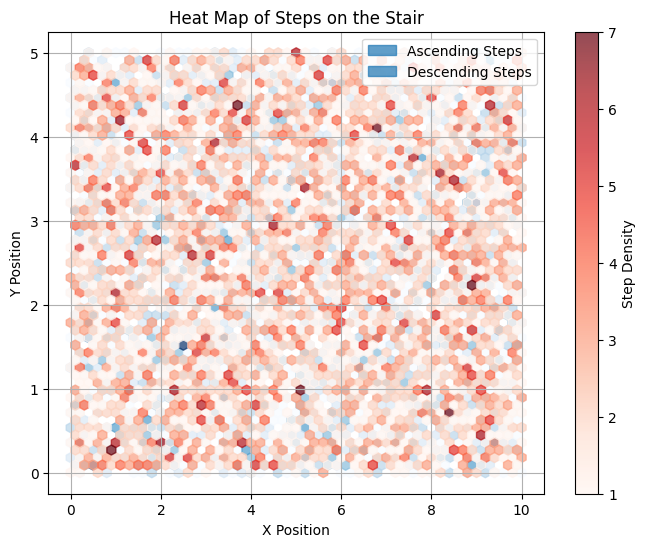

In [22]:
class Stair:
    def __init__(self, vertices, tread, width):
        self.vertices = vertices  # Coordinates of the stair vertices
        self.tread = tread  # Depth of each step
        self.width = width  # Width of the stair
        self.steps = []  # List to store steps (x, y, Agent)

    def add_step(self, x, y, agent):
        """
        Add a step to the list of steps.

        Args:
            x (float): X-coordinate of the center of the step.
            y (float): Y-coordinate of the center of the step.
            agent (Agent): The Agent object that made the step.
        """
        self.steps.append({"x": x, "y": y, "agent": agent})

    def plot_heat_map(self):
        """
        Plot a heat map of the steps on the stair, differentiating between ascending and descending steps.
        """
        # Separate ascending and descending steps
        ascending_steps = [(step['x'], step['y']) for step in self.steps if step['agent'].direction == 'ascending']
        descending_steps = [(step['x'], step['y']) for step in self.steps if step['agent'].direction == 'descending']

        # Create scatter plot data
        if ascending_steps:
            asc_x, asc_y = zip(*ascending_steps)
        else:
            asc_x, asc_y = [], []

        if descending_steps:
            desc_x, desc_y = zip(*descending_steps)
        else:
            desc_x, desc_y = [], []

        # Create the heat map
        plt.figure(figsize=(8, 6))
        plt.hexbin(asc_x, asc_y, gridsize=50, cmap='Blues', mincnt=1, alpha=0.7, label='Ascending Steps')
        plt.hexbin(desc_x, desc_y, gridsize=50, cmap='Reds', mincnt=1, alpha=0.7, label='Descending Steps')

        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title('Heat Map of Steps on the Stair')
        plt.legend()
        plt.colorbar(label='Step Density')
        plt.grid(True)
        plt.show()

# Example usage
if __name__ == "__main__":
    # Create a stair
    stair = Stair(vertices=[(0, 0), (10, 0), (10, 5), (0, 5)], tread=1, width=10)

    # Create a large number of agents
    agents = [Agent(unique_id=i, age=30, sex='M', height=170, weight=70, velocity=1, 
                    direction='ascending' if i % 2 == 0 else 'descending', 
                    group_id=i // 10, position=(0, 0, 0), foot='left') for i in range(1000)]

    # Simulate steps
    np.random.seed(42)
    for agent in agents:
        for _ in range(np.random.randint(5, 15)):
            x = np.random.uniform(0, 10)
            y = np.random.uniform(0, 5)
            stair.add_step(x, y, agent)

    # Plot the heat map
    stair.plot_heat_map()


## Simulation Class

In [ ]:
class Simulation:
    def __init__(self, staircase_params, lambda_rate, simulation_duration):
        self.staircase = Staircase(**staircase_params)
        self.lambda_rate = lambda_rate
        self.simulation_duration = simulation_duration
        self.time = 0
        self.agents = []
        self.arrival_times = self.generate_poisson_arrivals(lambda_rate, simulation_duration)

    @staticmethod
    def generate_poisson_arrivals(rate, duration):
        # Simulates a Poisson arrival process, returning a set of group arrival times
        arrivals = []
        current_time = 0

        while current_time < duration:
            # Generate interarrival time
            interarrival_time = np.random.exponential(1 / rate)
            current_time += interarrival_time
            if current_time < duration:
                arrivals.append(current_time)

        return arrivals


    def simulate(self):
        group_id = 0
        while self.time < self.simulation_duration:
            
            # Introduce groups according to the arrival times
            if len(self.arrival_times) > 0 and self.time >= self.arrival_times[0]:
                self.arrival_times = self.arrival_times[1:]  # Remove the first arrival time
                group = self.initialize_group(group_id)
                self.agents.extend(group)
                group_id += 1

            # Update agents
            active_agents = []
            for agent in self.agents:
                if agent.active:
                    agent.update_position(self.utility_function, self.agents, self.staircase)
                    self.staircase.record_footstep(agent.position[2], agent.position[0], agent.position[1])
                    if agent.active:  # Still active after update
                        active_agents.append(agent)
            self.agents = active_agents

            self.time += 1

    @staticmethod
    def utility_function(agent, agents, staircase):
        # Simplified utility function
        destination_force = -np.linalg.norm(agent.position - agent.destination)
        repulsion = 0
        for other_agent in agents:
            if other_agent != agent:
                distance = np.linalg.norm(agent.position - other_agent.position)
                if distance < 1.0:
                    repulsion += 1 / distance
                    
        return [destination_force + repulsion]  # Simplified example with one utility value

## Run the Simulation